# Node embedding

## Install necessary libraries

In [1]:
!pip uninstall -y fastai torch torchaudio torchvision
!pip install torch==2.0.0 --index-url https://download.pytorch.org/whl/cpu
!pip install torch-cluster torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric==2.3.1

Found existing installation: torch 2.0.0
Uninstalling torch-2.0.0:
  Successfully uninstalled torch-2.0.0
Looking in indexes: https://download.pytorch.org/whl/cpu
  Using cached https://download.pytorch.org/whl/cpu/torch-2.0.0-cp311-none-macosx_11_0_arm64.whl (55.8 MB)
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html


In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid

In [3]:
# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="CiteSeer", split="full")

[Dataset reference](https://arxiv.org/abs/1603.08861)

In [5]:
# Planetoid は torch_geometric の InMemoryDataset を継承している
# そのため、torch_geometric での学習が容易である
print(f"データセットの型 : {type(dataset)}")
print(f"ネットワークの型 : {type(dataset._data)}")

データセットの型 : <class 'torch_geometric.datasets.planetoid.Planetoid'>
ネットワークの型 : <class 'torch_geometric.data.data.Data'>


In [11]:
dataset._data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [4]:
from collections import Counter
from torch_geometric.utils.convert import to_networkx

citeseer_network = to_networkx(dataset._data, node_attrs=["y"])
print(f"Network type:", {type(citeseer_network)})
print(f"Number of nodes: {citeseer_network.number_of_nodes()}")
print(f"Number of edges: {citeseer_network.number_of_edges()}")

Network type: {<class 'networkx.classes.digraph.DiGraph'>}
Number of nodes: 3327
Number of edges: 9104


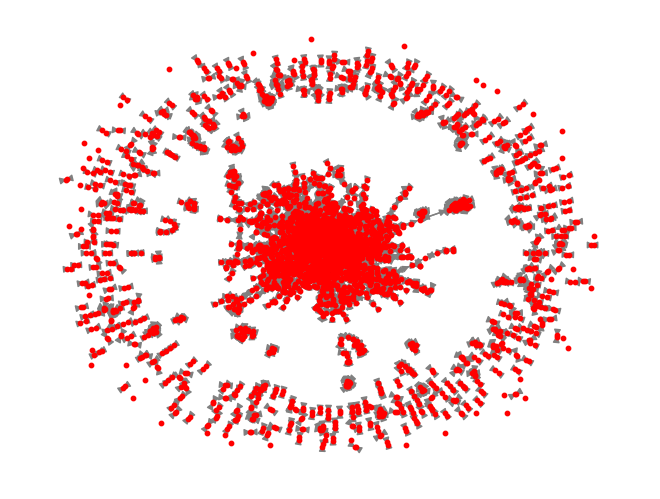

In [9]:
nx.draw(citeseer_network, node_size=10, node_color="red", edge_color="gray")

In [10]:
citeseer_network.nodes(data=True)

NodeDataView({0: {'y': 3}, 1: {'y': 1}, 2: {'y': 5}, 3: {'y': 5}, 4: {'y': 3}, 5: {'y': 1}, 6: {'y': 3}, 7: {'y': 0}, 8: {'y': 3}, 9: {'y': 5}, 10: {'y': 2}, 11: {'y': 4}, 12: {'y': 2}, 13: {'y': 1}, 14: {'y': 2}, 15: {'y': 3}, 16: {'y': 2}, 17: {'y': 4}, 18: {'y': 4}, 19: {'y': 0}, 20: {'y': 1}, 21: {'y': 5}, 22: {'y': 5}, 23: {'y': 3}, 24: {'y': 5}, 25: {'y': 2}, 26: {'y': 5}, 27: {'y': 2}, 28: {'y': 4}, 29: {'y': 2}, 30: {'y': 2}, 31: {'y': 2}, 32: {'y': 4}, 33: {'y': 5}, 34: {'y': 2}, 35: {'y': 3}, 36: {'y': 4}, 37: {'y': 5}, 38: {'y': 3}, 39: {'y': 3}, 40: {'y': 2}, 41: {'y': 1}, 42: {'y': 2}, 43: {'y': 1}, 44: {'y': 5}, 45: {'y': 1}, 46: {'y': 1}, 47: {'y': 4}, 48: {'y': 2}, 49: {'y': 3}, 50: {'y': 3}, 51: {'y': 2}, 52: {'y': 5}, 53: {'y': 2}, 54: {'y': 5}, 55: {'y': 1}, 56: {'y': 4}, 57: {'y': 1}, 58: {'y': 4}, 59: {'y': 2}, 60: {'y': 2}, 61: {'y': 3}, 62: {'y': 4}, 63: {'y': 5}, 64: {'y': 5}, 65: {'y': 1}, 66: {'y': 3}, 67: {'y': 3}, 68: {'y': 4}, 69: {'y': 2}, 70: {'y': 4}, 71

- Briefly view the dataset.

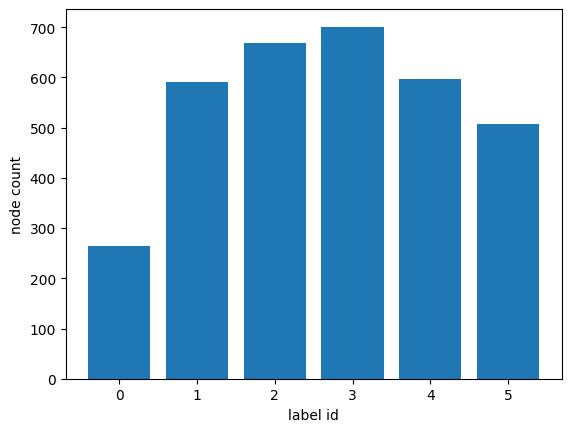

In [5]:
# Get ID for each papers to technial field
labels = nx.get_node_attributes(citeseer_network, "y")
label_counter = Counter(labels.values())
plt.bar(
    label_counter.keys(),
    label_counter.values(),
    tick_label=[f"{k}" for k in label_counter.keys()],
)
plt.xlabel("label id")
plt.ylabel("node count")
plt.show()

In [7]:
from torch_geometric.transforms import RandomNodeSplit

# Split nodes into train and test
node_splitter = RandomNodeSplit(split="train_rest", num_splits=1, num_val=0.0, num_test=0.4,key="y")
splitted_data = node_splitter(dataset._data)

In [8]:
print(splitted_data.node_attrs())
print(f"Number of train nodes: {splitted_data.train_mask}")
print(f"Number of test nodes: {splitted_data.test_mask}")
# print(f"Number of test nodes: {splitted_data.val_mask}")

['test_mask', 'train_mask', 'y', 'x', 'val_mask']
Number of train nodes: tensor([ True, False,  True,  ...,  True,  True, False])
Number of test nodes: tensor([False,  True, False,  ..., False, False,  True])


## Variance learning with node2vec

In [10]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:0010.5 MB/s eta 0:00:01


In [14]:
import optuna
from torch_geometric.nn import Node2Vec
import torch
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define hyperparameters to search
    embedding_dim = trial.suggest_int('embedding_dim', 16, 128)
    walk_length = trial.suggest_int('walk_length', 10, 30)
    max_context = min(15, walk_length)
    context_size = trial.suggest_int('context_size', 5, max_context)
    walks_per_node = trial.suggest_int('walks_per_node', 5, 20)
    p = trial.suggest_float('p', 0.25, 4.0, log=True)
    q = trial.suggest_float('q', 0.25, 4.0, log=True)
    lr = trial.suggest_float('lr', 1e-4, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [8, 16, 32, 64])
    num_epochs = trial.suggest_int('num_epochs', 50, 150)
    
    # Create Node2Vec model with suggested parameters
    model = Node2Vec(
        splitted_data.edge_index,
        embedding_dim=embedding_dim,
        walk_length=walk_length,
        context_size=context_size,
        walks_per_node=walks_per_node,
        num_negative_samples=1,
        p=p,
        q=q,
        sparse=False,
    ).to(device="cpu")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Training
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        
        loader = model.loader(batch_size=batch_size, shuffle=True)
        
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw, neg_rw)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch + 1) % 20 == 0:
            # Report intermediate loss to Optuna
            trial.report(total_loss / len(loader), epoch)
            
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
     # Generate node embeddings
    model.eval()
    with torch.no_grad():
        embeddings = model().detach().numpy()
    
    # Train a logistic regression classifier using the embeddings
    classifier = LogisticRegression(max_iter=1000)
    classifier.fit(embeddings[splitted_data.train_mask], splitted_data.y[splitted_data.train_mask])
    
    # Evaluate on test set
    y_pred = classifier.predict(embeddings[splitted_data.test_mask])
    accuracy = accuracy_score(splitted_data.y[splitted_data.test_mask].numpy(), y_pred)
    
    return accuracy  # We want to maximize accuracy

In [15]:
# Create and run the Optuna study
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=50)  # Adjust number of trials as needed

# Print the best hyperparameters
print("Best trial:")
trial = study.best_trial
print(f"  Value (accuracy): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Create the best model using the optimized hyperparameters
best_model = Node2Vec(
    splitted_data.edge_index,
    embedding_dim=trial.params['embedding_dim'],
    walk_length=trial.params['walk_length'],
    context_size=trial.params['context_size'],
    walks_per_node=trial.params['walks_per_node'],
    num_negative_samples=1,
    p=trial.params['p'],
    q=trial.params['q'],
    sparse=False,
).to(device="cpu")

# You can now train this best model for the final time

[I 2025-03-25 21:38:02,786] A new study created in memory with name: no-name-5dbd8b70-128d-43cc-9013-89a2da799896
[I 2025-03-25 21:41:00,376] Trial 0 finished with value: 0.5454545454545454 and parameters: {'embedding_dim': 33, 'walk_length': 26, 'context_size': 11, 'walks_per_node': 6, 'p': 1.1496817332271951, 'q': 0.4528035556150337, 'lr': 0.015832913392013696, 'batch_size': 8, 'num_epochs': 121}. Best is trial 0 with value: 0.5454545454545454.
[I 2025-03-25 21:42:42,794] Trial 1 finished with value: 0.5717505634861006 and parameters: {'embedding_dim': 106, 'walk_length': 16, 'context_size': 6, 'walks_per_node': 15, 'p': 1.243639571101005, 'q': 0.9982208109633491, 'lr': 0.0023778771333704198, 'batch_size': 32, 'num_epochs': 75}. Best is trial 1 with value: 0.5717505634861006.
[I 2025-03-25 21:47:24,214] Trial 2 finished with value: 0.5702479338842975 and parameters: {'embedding_dim': 52, 'walk_length': 25, 'context_size': 13, 'walks_per_node': 9, 'p': 2.710773119536808, 'q': 2.906374

Best trial:
  Value (accuracy): 0.5762584522915102
  Params: 
    embedding_dim: 89
    walk_length: 11
    context_size: 10
    walks_per_node: 8
    p: 1.8586819361574682
    q: 1.4569060321666076
    lr: 0.0023170565046231138
    batch_size: 16
    num_epochs: 89


In [16]:
optimizer = torch.optim.Adam(best_model.parameters(), lr=trial.params['lr']) # User parameters from the best trial
epochs = trial.params['num_epochs']
batch_size = trial.params['batch_size']

# 学習ループ
print("Training best model...")
for epoch in tqdm(range(epochs)):
    best_model.train()
    total_loss = 0
    
    loader = best_model.loader(batch_size=batch_size, shuffle=True)
    
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = best_model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch: {epoch+1}, Loss: {total_loss / len(loader):.4f}")

# 埋め込みの生成
best_model.eval()
with torch.no_grad():
    embeddings = best_model().detach().numpy()

Training best model...


 22%|██▏       | 20/89 [00:16<00:59,  1.16it/s]

Epoch: 20, Loss: 1.5758


 45%|████▍     | 40/89 [00:32<00:38,  1.27it/s]

Epoch: 40, Loss: 0.8337


 67%|██████▋   | 60/89 [00:47<00:22,  1.28it/s]

Epoch: 60, Loss: 0.7692


 90%|████████▉ | 80/89 [01:03<00:07,  1.27it/s]

Epoch: 80, Loss: 0.7633


100%|██████████| 89/89 [01:10<00:00,  1.26it/s]


In [19]:
!pip install seaborn

In [24]:
# ロジスティック回帰によるノード分類の評価
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 学習
print("Evaluating node classification...")
classifier = LogisticRegression(max_iter=1000)
X_train = np.concatenate(
    (
        splitted_data.x[splitted_data.train_mask].detach().numpy(),
        embeddings[splitted_data.train_mask],
    ),
    axis=1,
) # Add node variance reference to characteristics
y_train = splitted_data.y[splitted_data.train_mask].numpy()
classifier.fit(X_train, y_train)

# # 予測と評価
# y_pred = classifier.predict(embeddings[splitted_data.test_mask])
# accuracy = accuracy_score(splitted_data.y[splitted_data.test_mask].numpy(), y_pred)
# print(f"Test Accuracy: {accuracy:.4f}")

# # 詳細な評価レポート
# print("\nClassification Report:")
# print(classification_report(splitted_data.y[splitted_data.test_mask].numpy(), y_pred))

# # 混合行列の可視化
# plt.figure(figsize=(10, 8))
# cm = confusion_matrix(splitted_data.y[splitted_data.test_mask].numpy(), y_pred)
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()

# # モデルの保存（オプション）
# torch.save(best_model.state_dict(), "best_node2vec_model.pt")
# print("Model saved as 'best_node2vec_model.pt'")

Evaluating node classification...


LogisticRegression(max_iter=1000)

In [ ]:
# テストデータに対する推論
X_test = np.concatenate(
    (
        splitted_data.x[splitted_data.test_mask].detach().numpy(),
        embeddings[splitted_data.test_mask],
    ),
) # Add node variance reference to characteristics
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = classifier.predict(X_test)

# 評価結果の表示
print(classification_report(y_true, y_pred))

TypeError: concatenate() got an unexpected keyword argument 'dim'

## Distribute papers into technical field with Logistic regression

In [24]:
embedding_matrix = model.embedding(
    torch.arange(splitted_data.num_nodes, device="cpu")
)

print(embedding_matrix.shape)

torch.Size([3327, 128])


In [25]:
# あらかじめ与えられた特徴量を用いたロジスティック回帰モデルの学習
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

baseline_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)
X_train = splitted_data.x[splitted_data.train_mask].numpy()
y_train = splitted_data.y[splitted_data.train_mask].numpy()
baseline_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [26]:
# 評価データに対する推論
X_test = splitted_data.x[splitted_data.test_mask].numpy()
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = baseline_classifier.predict(X_test)

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.39      0.42       101
           1       0.72      0.69      0.71       258
           2       0.72      0.67      0.70       289
           3       0.72      0.81      0.76       262
           4       0.75      0.78      0.77       227
           5       0.72      0.71      0.71       194

    accuracy                           0.71      1331
   macro avg       0.68      0.68      0.68      1331
weighted avg       0.70      0.71      0.70      1331



In [27]:
# ノードの分散表現を特徴量に加えたロジスティック回帰モデルの学習
n2v_classifier = LogisticRegression(
    max_iter=1000,
    random_state=0,
)
X_train = torch.cat(
    (
        splitted_data.x[splitted_data.train_mask],
        embedding_matrix[splitted_data.train_mask],
    ),
    dim=1,
).detach().numpy() # Add node variance reference to characteristics
y_train = splitted_data.y[splitted_data.train_mask].numpy()
n2v_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

In [28]:
# テストデータに対する推論
X_test = torch.cat(
    (
        splitted_data.x[splitted_data.test_mask],
        embedding_matrix[splitted_data.test_mask],
    ),
    dim=1,
).detach().numpy() # Add node variance reference to characteristics
y_true = splitted_data.y[splitted_data.test_mask].numpy()
y_pred = n2v_classifier.predict(X_test)

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.42      0.45       101
           1       0.72      0.69      0.70       258
           2       0.74      0.72      0.73       289
           3       0.74      0.80      0.77       262
           4       0.76      0.80      0.78       227
           5       0.74      0.75      0.74       194

    accuracy                           0.72      1331
   macro avg       0.70      0.69      0.69      1331
weighted avg       0.72      0.72      0.72      1331

